# Your Average Sentiment Network (AvgNet) NLP model

Now, we try different nlp model as given in this paper [1][4], known as Your Average Sentiment Network (AvgNet).

## Data Pre-processing and Preparation

This paper [1,4] calculates the n-grams of an input sentence and append them to the end of a sentence. Here, we'll use bi-grams. Briefly, a bi-gram is a pair of words/tokens that appear consecutively within a sentence.

For example, in the sentence "how are you ?", the bi-grams are: "how are", "are you" and "you ?".

The generate_bigrams function takes a sentence that has already been tokenized, calculates the bi-grams and appends them to the end of the tokenized list.

In [6]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [7]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language='en_core_web_sm',
                  preprocessing = generate_bigrams)

LABEL = data.LabelField(dtype=torch.long)

fields = [
    ('textID', None),
    ('text', TEXT),
    ('selected_text', None),
    ('sentiment', LABEL)
]

train_data, test_data, valid_data = data.TabularDataset.splits(
    path='/content/drive/MyDrive/Sentiment-Analysis/tweets1',
    train="Tweets.csv",
    test="Tweets.csv",
    validation="Tweets.csv",
    format="csv",
    skip_header=True,
    fields=fields
)



As before, we load the IMDb dataset and create the splits.

In [21]:
import random

train_data, test_data = train_data.split(random_state=random.seed(SEED))

train_data, valid_data = train_data.split(split_ratio=0.975, random_state=random.seed(SEED))


print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")



Number of training examples: 18756
Number of validation examples: 481
Number of testing examples: 8244


Build the vocab and load the pre-trained word embeddings.

In [9]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


LABEL.build_vocab(train_data)


#TEXT.build_vocab(train_data)
#LABEL.build_vocab(train_data)

And create the iterators.

In [10]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort = False, #don't sort test/validation data
    batch_size=BATCH_SIZE,
    device=device)


# Designing the deep NLP Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class NLPModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        #text = [sent len, batch size]

        embedded = self.embedding(text)

        #embedded = [sent len, batch size, emb dim]

        embedded = embedded.permute(1, 0, 2)

        #embedded = [batch size, sent len, emb dim]

        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)

        #pooled = [batch size, embedding_dim]

        return self.fc(pooled)

Next, we make the instance of our NLPModel1 class.

In [13]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 4
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = NLPModel1(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

Looking at the number of parameters in our model:

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ',str(count_parameters(model)),'trainable parameters')

The model has  2500604 trainable parameters


And copy the pre-trained vectors to our embedding layer.

In [15]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.4298,  0.8205, -1.4562,  ...,  1.4802,  0.2942,  1.3924],
        ...,
        [-0.8808, -0.8520,  0.8426,  ...,  0.0685, -1.3495, -0.7838],
        [ 0.1364, -0.6408, -0.7633,  ...,  0.0108, -1.3456,  1.3380],
        [ 1.1493, -2.6423, -1.2289,  ...,  0.4797, -0.9016,  0.5908]])

Not forgetting to zero the initial weights of our unknown and padding tokens.

In [16]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Train the Model

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [29]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    device = preds.device  # get the device of predictions
    y = y.to(device)       # move labels to same device
    max_preds = preds.argmax(dim=1, keepdim=True)  # get index of max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.tensor(y.shape[0], dtype=torch.float, device=device)


We define a function for training our model...

In [24]:
train_loss_values=[]
train_acc_values=[]


def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text)

        loss = criterion(predictions, batch.sentiment)
        acc = categorical_accuracy(predictions, batch.sentiment)


        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

print(LABEL.vocab.stoi)

defaultdict(None, {'neutral': 0, 'positive': 1, 'negative': 2})


We define a function for testing our model...

In [39]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text)

            loss = criterion(predictions, batch.sentiment)

            acc = categorical_accuracy(predictions, batch.sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text = batch.text.to(device)
            labels = batch.sentiment.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_preds.append(predictions.argmax(dim=1).cpu())  # move to CPU
            all_labels.append(labels.cpu())                     # move to CPU

    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute average precision/recall
    num_classes = all_preds.max().item() + 1
    precision_list = []
    recall_list = []

    for cls in range(num_classes):
        tp = ((all_preds == cls) & (all_labels == cls)).sum().item()
        fp = ((all_preds == cls) & (all_labels != cls)).sum().item()
        fn = ((all_preds != cls) & (all_labels == cls)).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)

    avg_precision = sum(precision_list) / num_classes
    avg_recall = sum(recall_list) / num_classes

    return epoch_loss / len(iterator), epoch_acc / len(iterator), avg_precision, avg_recall, all_preds, all_labels


As before, we'll implement a useful function to tell us how long an epoch takes.

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

In [30]:
N_EPOCHS = 25


train_loss_values=[]
train_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #if valid_loss < best_valid_loss:
    #best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'fastModel1Tweets.pt')

    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    #print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 0 m  1 s
	Train Loss:  1.1623355773992317  | Train Acc:  44.10348836765733 %
Epoch:  2  | Epoch Time: 0 m  1 s
	Train Loss:  0.9703321093736693  | Train Acc:  59.071656978407574 %
Epoch:  3  | Epoch Time: 0 m  1 s
	Train Loss:  0.8347046570722447  | Train Acc:  66.79287791252136 %
Epoch:  4  | Epoch Time: 0 m  1 s
	Train Loss:  0.7359154525191285  | Train Acc:  71.59636627796084 %
Epoch:  5  | Epoch Time: 0 m  1 s
	Train Loss:  0.6612722229125888  | Train Acc:  74.89447674085928 %
Epoch:  6  | Epoch Time: 0 m  1 s
	Train Loss:  0.6005812455055326  | Train Acc:  77.89680232835371 %
Epoch:  7  | Epoch Time: 0 m  1 s
	Train Loss:  0.5473119849382445  | Train Acc:  80.37703487762185 %
Epoch:  8  | Epoch Time: 0 m  1 s
	Train Loss:  0.5018288982468982  | Train Acc:  82.4587209280147 %
Epoch:  9  | Epoch Time: 0 m  1 s
	Train Loss:  0.4605426684368488  | Train Acc:  84.2324127845986 %
Epoch:  10  | Epoch Time: 0 m  1 s
	Train Loss:  0.42223697214625605  | Train Acc: 

In [31]:
print(len(train_loss_values))
print(train_loss_values)
print(len(train_acc_values))
print(train_acc_values)

with open('the_model1_performance_tweets.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss)


    #for listitem in train_loss_values:
     #   filehandle.write(listitem)

25
[1.1623355773992317, 0.9703321093736693, 0.8347046570722447, 0.7359154525191285, 0.6612722229125888, 0.6005812455055326, 0.5473119849382445, 0.5018288982468982, 0.4605426684368488, 0.42223697214625605, 0.3873660737345385, 0.3559812544390213, 0.32662882849920627, 0.3002076373890389, 0.2759674804848294, 0.2526760219834572, 0.23188833376002865, 0.21329654333896414, 0.19581628046756566, 0.17982840943475104, 0.16506382956407792, 0.15169411868203517, 0.13948957832573458, 0.12751406536026055, 0.1172885219891404]
25
[0.4410348836765733, 0.5907165697840757, 0.6679287791252136, 0.7159636627796084, 0.7489447674085927, 0.7789680232835371, 0.8037703487762186, 0.8245872092801471, 0.842324127845986, 0.8599840115669162, 0.8765741278958875, 0.8882063952989356, 0.9027252906976744, 0.9131613372370254, 0.9221613372481147, 0.9307412790697674, 0.9379520348338194, 0.9447267442248588, 0.9507427325082379, 0.9558662790198659, 0.9604287790697674, 0.964478197624517, 0.9682369186434635, 0.9710915697175403, 0.97

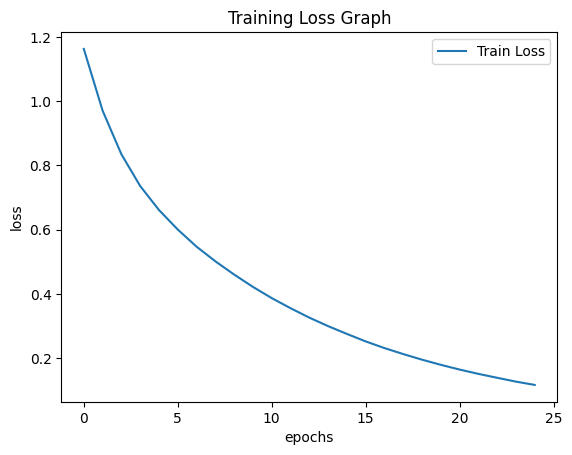

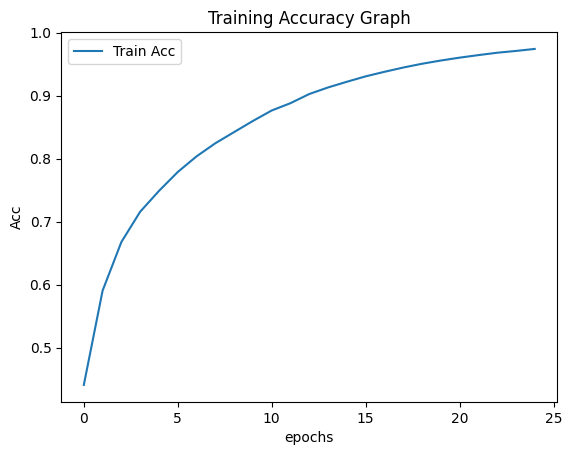

In [32]:
from matplotlib import pyplot as plt


train_loss_values=[]
train_acc_values=[]


# open file and read the content in a list
with open('the_model1_performance_tweets.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()

    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    train_acc_values=[float(i) for i in filecontents[1].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [40]:
model.load_state_dict(torch.load('fastModel1Tweets.pt'))

# Load model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('fastModel1Tweets.pt', map_location=device))
model.to(device)

# Evaluate
test_loss, test_acc, test_prec, test_recall, all_preds, all_labels = evaluate_test(model, test_iterator, criterion, device)

# Write to CSV
import csv
with open('sentiment_results_model1_tweets.csv', mode='w', newline='') as sent_file:
    writer = csv.writer(sent_file)
    writer.writerow(['Our Prediction', 'Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'])

    for pred, label in zip(all_preds, all_labels):
        writer.writerow([pred.item(), label.item()])

print(f'Test Loss: {test_loss:.4f} | Acc: {test_acc*100:.2f}% | Precision: {test_prec:.4f} | Recall: {test_recall:.4f}')
print("Results are also written in sentiment_results_model1_tweets.csv")


Test Loss: 0.1036 | Acc: 97.89% | Precision: 0.9806 | Recall: 0.9778
Results are also written in sentiment_results_model1_tweets.csv


In [42]:
import pandas as pd
model_df1 = pd.read_csv ("/content/drive/MyDrive/Sentiment-Analysis/tweets1/Tweets.csv")
model_df1.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


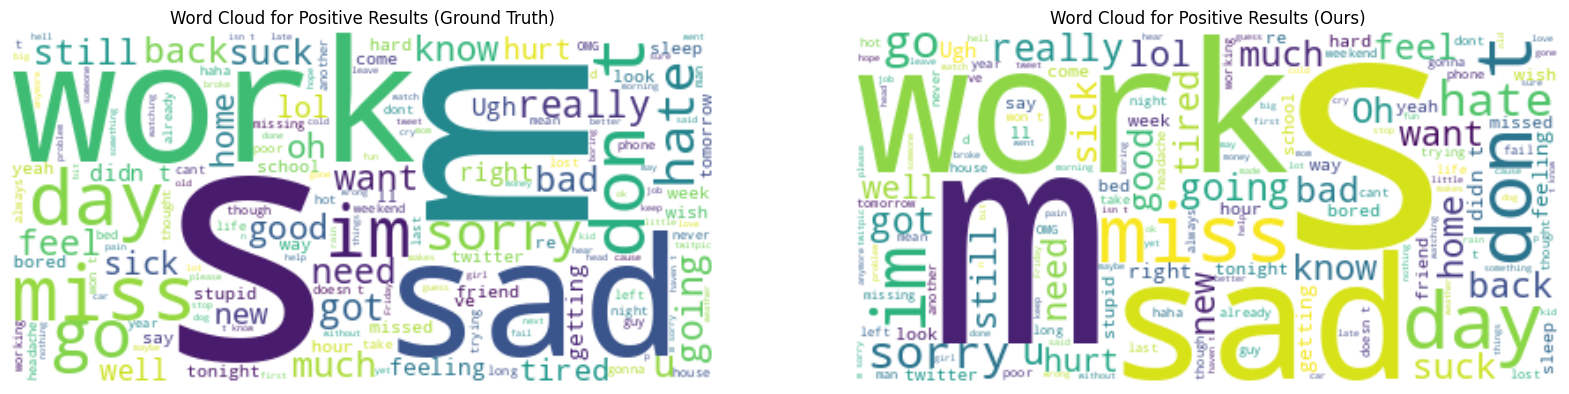

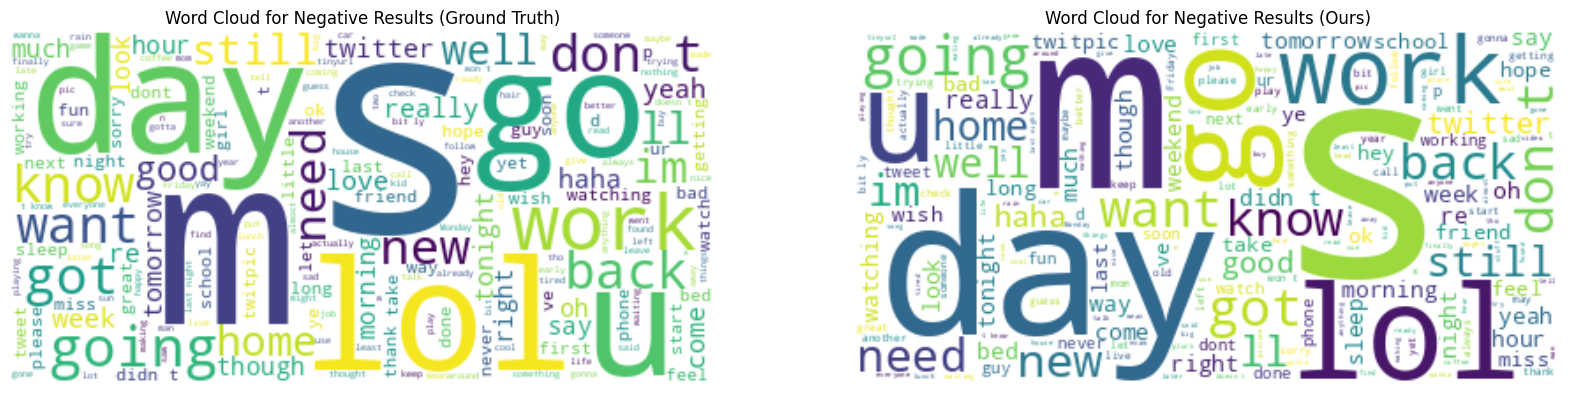

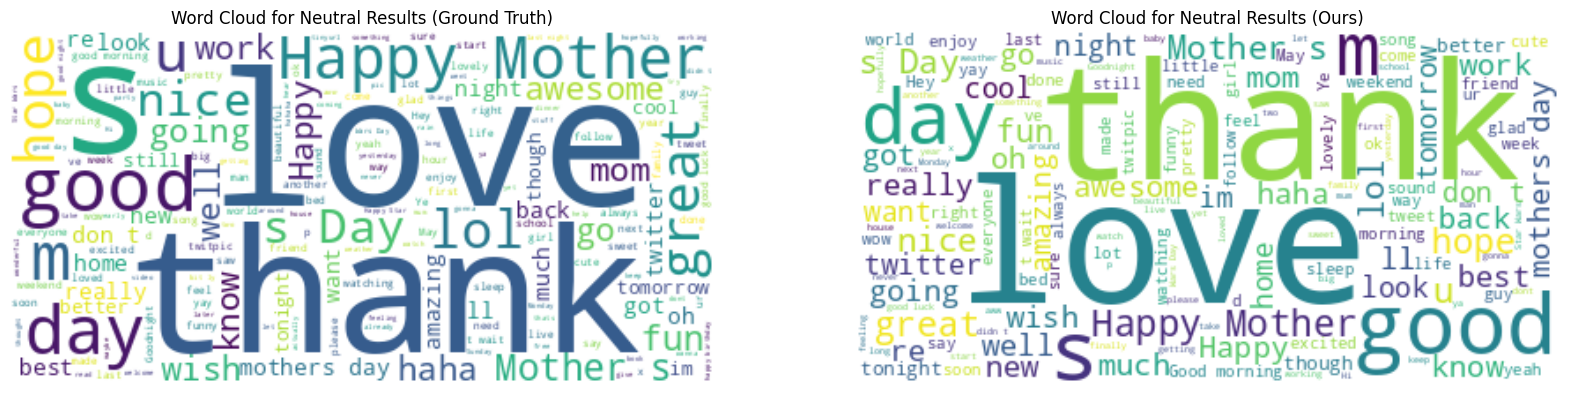

In [55]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='/content/drive/MyDrive/Sentiment-Analysis/tweets1'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("/content/sentiment_results_model1_tweets.csv")


#POSITIVE

allTextPos=""
allTextPosGT=""

for ind in model_df.index:
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==2.0:
         allTextPosGT=allTextPosGT+" "+model_df1['text'][ind]

     if model_df['Our Prediction'][ind]==2.0:
         allTextPos=allTextPos+" "+model_df1['text'][ind]



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

for ind in model_df.index:
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==2.0:
         allTextPosGT=allTextPosGT+" "+model_df1['text'][ind]

     if model_df['Our Prediction'][ind]==2.0:
         allTextPos=allTextPos+" "+model_df1['text'][ind]


#NEGATIVE

allTextNeg=""
allTextNegGT=""

for ind in model_df.index:
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==0.0:
         allTextNegGT=allTextNegGT+" "+str(model_df1['text'][ind])

     if model_df['Our Prediction'][ind]==0.0:
         allTextNeg=allTextNeg+" "+str(model_df1['text'][ind])


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# NEUTRAL

allTextNeutral=""
allTextNeutralGT=""

for ind in model_df.index:
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==1.0:
         allTextNeutralGT=allTextNeutralGT+" "+model_df1['text'][ind]

     if model_df['Our Prediction'][ind]==1.0:
         allTextNeutral=allTextNeutral+" "+model_df1['text'][ind]


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeutralGT)

# Display the generated image:
plt.title('Word Cloud for Neutral Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeutral)

# Display the generated image:
plt.title('Word Cloud for Neutral Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()